# Lecture 6) Image Classification with Convolutional Neural Networks

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn as sl

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn import neighbors
from sklearn.model_selection import cross_val_score
from sklearn import linear_model

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import BaggingClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import AdaBoostRegressor

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor


%matplotlib inline
import scipy as sc
import math as ma
from scipy import linalg, optimize, constants, interpolate, special, stats
from math import exp, pow, sqrt, log

import seaborn as sns #special Graphics
import statsmodels.api as sm
import statsmodels.stats.api as sms


import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import datasets, layers, models, utils

from keras.models import Sequential
from keras.layers import InputLayer,Dense, Activation, Conv2D, MaxPooling2D, Dropout, Flatten

from keras.optimizers import SGD #Stochastic Gradient Descent
from keras.utils import to_categorical  
from keras.utils import plot_model

from tensorflow.keras.optimizers.schedules import ExponentialDecay


from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import applications
from tensorflow.keras.applications import EfficientNetB5

import pathlib
import ssl
ssl._create_default_https_context = ssl._create_unverified_context


In [2]:
# updatable plot

from IPython.display import clear_output
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

In the lecture, we saw that Convolutional Neural Networks (CNNs) are optimal for image classification tasks.  

The combination of convolution and pooling layers ensures that multidimensional input is preprocessed in a way that extracts relevant features and filters out redundant information for the classification task.  

In Keras, setting up such a CNN is very straightforward. The framework provides exactly the layers we need: convolution layers and pooling layers.

First, we load a dataset to test the concepts. The CIFAR-10 dataset is perfectly suited for this purpose.

You can find more information here: 

https://keras.io/api/datasets/cifar10/

CIFAR-10 Dataset Documentation.

The dataset contains 50,000 training images with labels (32x32 pixels, RGB color) for 10 distinguishable classes:

0   airplane  
1	automobile  
2	bird  
3	cat  
4	deer  
5	dog  
6	frog  
7	horse  
8	ship  
9	truck  

The test set contains 10.000 images.

In [3]:
import pathlib
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
#dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
#data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
#data_dir = pathlib.Path(data_dir)

In [4]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()


In [5]:
test_labels

array([[3],
       [8],
       [8],
       ...,
       [5],
       [1],
       [7]], dtype=uint8)

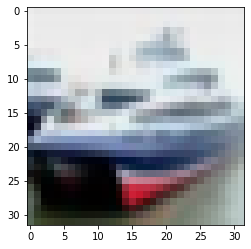

In [6]:
plt.imshow(test_images[1])

Let's plot some of the images:

Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


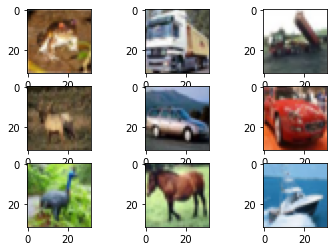

In [7]:
# summarize loaded dataset
print('Train: X=%s, y=%s' % (train_images.shape, train_labels.shape))
print('Test: X=%s, y=%s' % (test_images.shape, test_labels.shape))
# plot first few images
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    plt.imshow(train_images[i])
# show the figure
plt.show()

You can already see that solving the classification task might not be straightforward for a neural network since the images are not particularly high-resolution. This task is one of the more challenging benchmarks for CNNs.

Here, you can explore how different architectures perform on this task. For example, the CIFAR-10 dataset has been used extensively to benchmark well-known architectures like VGG, ResNet, and DenseNet. The comparative results of these architectures provide insight into their strengths and limitations for tasks involving lower-resolution images.

For details, you can check resources like:

Papers with Code: CIFAR-10 Benchmark Results
The official documentation of specific architectures in the Keras API or TensorFlow.

https://paperswithcode.com/sota/image-classification-on-cifar-10

With the latest advancements in neural networks (e.g., transformers), even this challenging task seems to have been effectively solved. However, we will begin with a "hand-crafted," very simple attempt—a minimal network architecture.

Before that, we need to convert the labels into a one-hot encoded target vector. This encoding ensures that the labels are represented as binary vectors, making them compatible with the categorical cross-entropy loss function, which is typically used for multi-class classification tasks in neural networks.

For example, in the CIFAR-10 dataset, if a label corresponds to class 3, it would be converted into the vector [0, 0, 0, 1, 0, 0, 0, 0, 0, 0].

In [8]:
# one hot encode target values
trainY = to_categorical(train_labels)
testY = to_categorical(test_labels)

np.shape(testY)

(10000, 10)

In [9]:
trainY

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

Then we standardize the input. Since we are dealing with images (intensity values represented as numbers: Min=0, Max=255), this is quite straightforward.

After standardization, the range of the data will fall within the interval from 0 to 1:

This scaling ensures that all pixel values are normalized, which helps the neural network learn more efficiently and converge faster during training.

In [10]:
# in floats konvertieren
trainX = train_images.astype('float32')
testX = test_images.astype('float32')

# auf einen range von 0-1 normalisieren
trainX = trainX / 255.0
testX = testX / 255.0

### 6.1) Custom-Built CNNs in Keras

Now, we can set up our first Keras Sequential() model with Conv2D and pooling layers.

The first layer needs information about the dimensions of the input. All subsequent layers are automatically configured to match the dimensions.

After the sequence of convolution and pooling layers, a Flatten layer is used to generate the feature vector.

This feature vector serves as the input to the actual classifier, which in our case is simply a Dense layer...

In [11]:
#Modell initialisieren
modelCNN_cifar10 = Sequential()

#Modell aufsetzen
modelCNN_cifar10.add(Conv2D(30,                      #number of Filters
                          kernel_size=(3,3),         #Dimension of window
                          strides=(1,1),             #step size
                          padding='same',            #Padding: same=dim(in)=dim(out), valid=no Padding
                          activation='relu',         #activation function
                          input_shape=(32,32,3)))    #Dimension of Inputs

modelCNN_cifar10.add(MaxPooling2D(pool_size=(3, 3),  #MaxPooling 3x3
                                  strides=(1,1)))    #step size

modelCNN_cifar10.add(Conv2D(30, kernel_size=(3,3), 
                          strides=(1,1),             #step size
                          padding='same',            #Padding: same=dim(in)=dim(out), valid=no Padding
                          activation='relu'))

modelCNN_cifar10.add(MaxPooling2D(pool_size=(3, 3),
                                  strides=(1,1)))

modelCNN_cifar10.add(Flatten())                       #generate Feature-Vector
modelCNN_cifar10.add(Dense(100,activation='relu'))
modelCNN_cifar10.add(Dense(10, activation='softmax')) #dense layer - acts as classifier!


In [12]:
modelCNN_cifar10.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 30)        840       
                                                                 
 max_pooling2d (MaxPooling2  (None, 30, 30, 30)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 30)        8130      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 28, 28, 30)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 23520)             0         
                                                                 
 dense (Dense)               (None, 100)               2

In the model summary, you can clearly see that even this small CNN has a significant number of parameters that need to be learned.  

Accordingly, the training process is considerably slower compared to what we have observed so far...

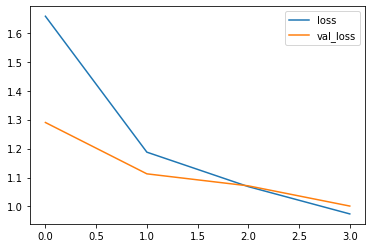

100/100 [==============================] - 79s 793ms/step - loss: 0.9742 - accuracy: 0.6607 - val_loss: 1.0013 - val_accuracy: 0.6520


In [13]:
#initialize model
modelCNN_cifar10 = Sequential()

#Modell aufsetzen
modelCNN_cifar10.add(Conv2D(60,                      #number of filters
                          kernel_size=(3,3),         #dimension of window
                          strides=(1,1),             #step size
                          padding='same',            #Padding: same=dim(in)=dim(out), valid=no Padding
                          activation='relu',         #activation function
                          input_shape=(32,32,3)))    #Dimension of Input

modelCNN_cifar10.add(MaxPooling2D(pool_size=(3, 3),  #MaxPooling  3x3
                                  strides=(1,1)))    #step size

modelCNN_cifar10.add(Conv2D(30, kernel_size=(3,3), 
                          strides=(1,1),             #step size
                          padding='same',            #Padding: same=dim(in)=dim(out), valid=no Padding
                          activation='relu'))

modelCNN_cifar10.add(MaxPooling2D(pool_size=(3, 3),
                                  strides=(1,1)))

modelCNN_cifar10.add(Flatten())                       #generate Feature-Vector
modelCNN_cifar10.add(Dense(100,activation='relu'))
modelCNN_cifar10.add(Dense(10, activation='softmax')) #dense layer - acts as classifier!

#Adam
myAdam=keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

#RMS Prop
myRMSprop=keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)

# Define a learning rate schedule
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.01,  # initial learning rate
    decay_steps=100000,          # number of steps before it starts
    decay_rate=0.96,             # Factor of decay
    staircase=False              # smooth decay if False, step decay if True
)

# SGD optimizer with learning rate schedule
sgd = SGD(learning_rate=lr_schedule, momentum=0.9, nesterov=True)

#Compile model
modelCNN_cifar10.compile(
    optimizer=myAdam, 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

#train model
historyCNN_cifar10=modelCNN_cifar10.fit(trainX, trainY, 
          validation_data=(testX, testY),                              
          epochs=4,
          batch_size=500,
          verbose=1,
          callbacks=[plot_losses])

In [14]:
modelCNN_cifar10.evaluate(testX, testY)

313/313 [==============================] - 8s 26ms/step - loss: 1.0013 - accuracy: 0.6520


[1.0013457536697388, 0.6520000100135803]

The accuracy is not particularly impressive. However, we are working with a mini-network :-)  

The hyperparameters have also not yet been optimized...

In addition, considering regularization is crucial for such drastically overparameterized networks. Beyond the familiar techniques (weight decay, pruning, ensembles, etc.), there is a particularly elegant solution: Dropout.  

With Dropout, random connectors are blocked during each learning iteration.
This means the network looks slightly different for every learning step and is trained on fewer active parameters.
Dropout acts somewhat like an ensemble solution that is only active during training.
The Keras Dropout layer can easily be added to a sequential model.
The parameter specifies what percentage of weights should be disabled: 

modelCNN_cifar10.add(Dropout(0.25))


Dropout was first discussed by Hinton in 2012. In the original approach, dropout layers were added after the dense layers of the classifier, not after the Conv2D layers.  


https://arxiv.org/pdf/1207.0580.pdf

Later, however, it was shown that for complex problems, a moderate dropout (e.g., drop rates of 0.05, 0.1, etc.) after Conv2D layers can also be beneficial.

Here’s an example using two dropout layers:

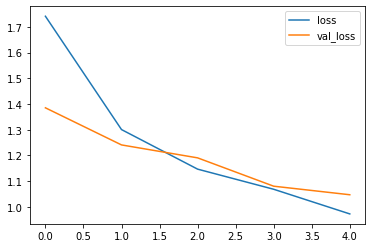

100/100 [==============================] - 96s 963ms/step - loss: 0.9730 - accuracy: 0.6619 - val_loss: 1.0475 - val_accuracy: 0.6355


In [15]:
#Initialization
modelCNN_cifar10 = Sequential()

#define Model
modelCNN_cifar10.add(Conv2D(60,                      #number of filters
                          kernel_size=(3,3),         #dimension of window
                          strides=(1,1),             #step size
                          padding='same',            #Padding: same=dim(in)=dim(out), valid=no Padding
                          activation='relu',         #Activation function
                          input_shape=(32,32,3)))    #Dimension of Input

modelCNN_cifar10.add(Dropout(0.05))

modelCNN_cifar10.add(MaxPooling2D(pool_size=(3, 3),  #MaxPooling 3x3
                                  strides=(1,1)))    #step size


modelCNN_cifar10.add(Conv2D(30, kernel_size=(3,3), 
                          strides=(1,1),             #step size
                          padding='same',            #Padding: same=dim(in)=dim(out), valid=no Padding
                          activation='relu'))

modelCNN_cifar10.add(Dropout(0.05))

modelCNN_cifar10.add(MaxPooling2D(pool_size=(3, 3),
                                  strides=(1,1)))


modelCNN_cifar10.add(Flatten())                       #generate feature vector
modelCNN_cifar10.add(Dense(100,activation='relu'))
modelCNN_cifar10.add(Dense(10, activation='softmax')) #dense layer - acts as classifier!

#Adam
myAdam=keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

#RMS Prop
myRMSprop=keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)

# define a learning rate schedule
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.01,  # initial learning rate
    decay_steps=100000,          # number of steps before it starts
    decay_rate=0.96,             # Factor of decay
    staircase=False              # smooth decay if False, step decay if True
)

# SGD optimizer with learning rate schedule
sgd = SGD(learning_rate=lr_schedule, momentum=0.9, nesterov=True)

#compile model
modelCNN_cifar10.compile(
    optimizer=myAdam, 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

#train model
historyCNN_cifar10=modelCNN_cifar10.fit(trainX, trainY, 
          validation_data=(testX, testY),                              
          epochs=5,
          batch_size=500,
          verbose=1,
          callbacks=[plot_losses])

In [16]:
modelCNN_cifar10.evaluate(testX, testY)

313/313 [==============================] - 8s 24ms/step - loss: 1.0475 - accuracy: 0.6355


[1.0474658012390137, 0.6355000138282776]

### Exercise 1)

The two minimalist CNNs above are, of course, still far from being optimally configured!

- Experiment with the two networks by attempting to optimize the hyperparameters. This includes tuning the learning rate, the learning algorithm, and key parameters like the number of hidden layers in the classifier and the number of neurons connected within them.

- Consider additional strategies to improve these small networks. Think about what else could be done to enhance their performance and generalization capabilities.

### 6.2) Data Augmentation

Especially when there are limited training data or highly redundant samples, it can be helpful to generate synthetic data from the given samples. In the case of images, it makes sense to slightly rotate or shift the existing examples to create "new" data points for training.

In Keras, the ImageDataGenerator is a great tool for this purpose.  

It is quite efficient because it modifies the original data during training.  

This means that the model sees a slightly altered version of the original inputs during each epoch. No additional data needs to be stored, which can significantly speed up the process!

### Rotation

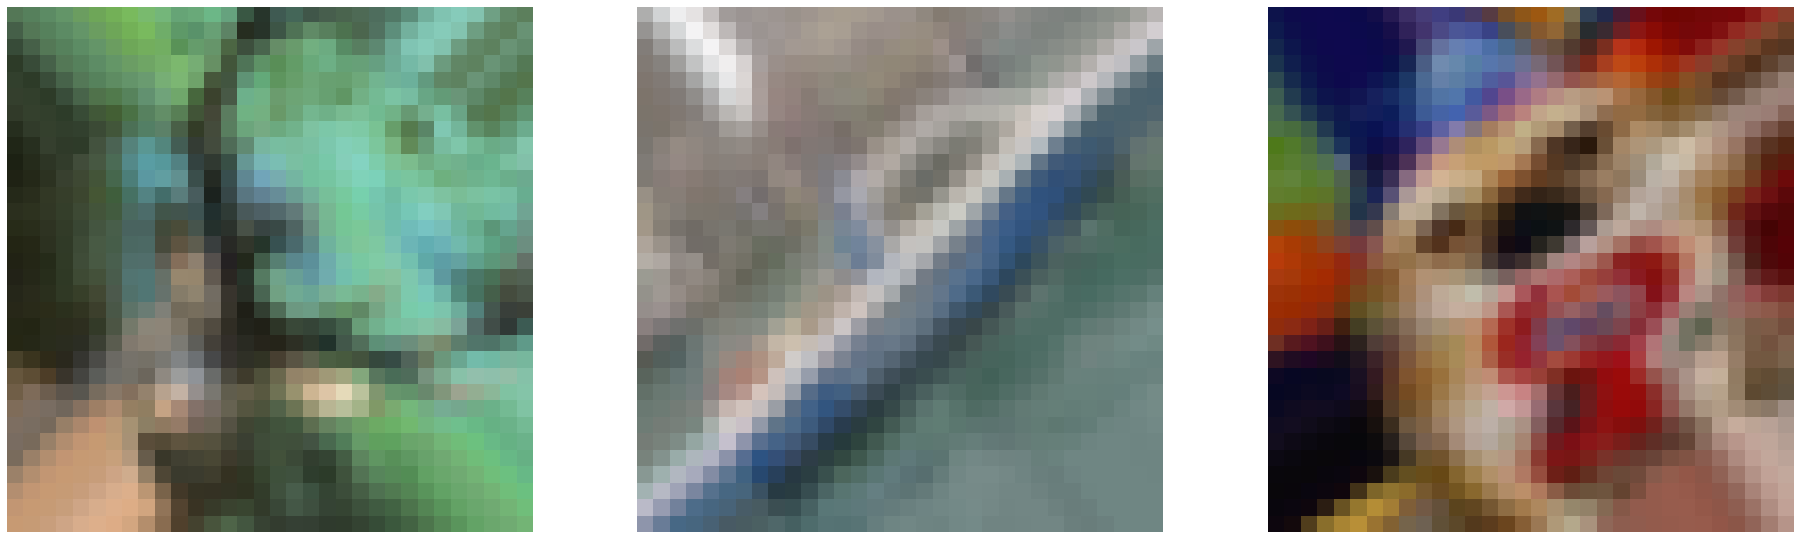

In [17]:
#Image Data Augmentation
from keras.preprocessing.image import ImageDataGenerator

# ImageDataGenerator rotation
datagen = ImageDataGenerator(rotation_range=90, fill_mode='nearest')
# iterator
aug_iter = datagen.flow(train_images, batch_size=1)
# generate samples and plot
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(32,32))
# generate batch of images
for i in range(3):
    # convert to unsigned integers
    image = next(aug_iter)[0].astype('uint8')
    # plot image
    ax[i].imshow(image)
    ax[i].axis('off')

### Flipping

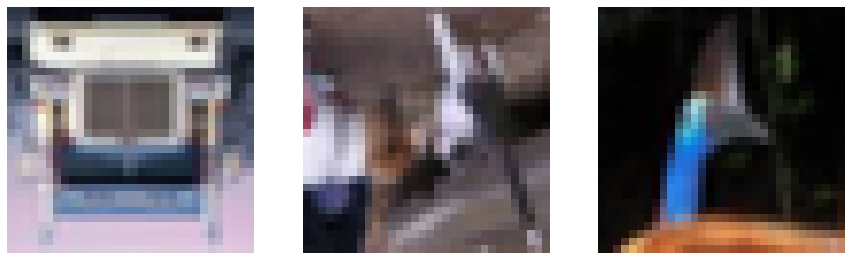

In [18]:
# ImageDataGenerator flipping
datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
# iterator
aug_iter = datagen.flow(train_images, batch_size=1)
# generate samples and plot
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,15))
# generate batch of images
for i in range(3):
    # convert to unsigned integers
    image = next(aug_iter)[0].astype('uint8')
    # plot image
    ax[i].imshow(image)
    ax[i].axis('off')

now an application for our example from above:

In [19]:
# define ImageDataGenerator

datagen = ImageDataGenerator(
rotation_range=10, # Rotation
width_shift_range=0.2, # horizontal Shift
height_shift_range=0.2, # vertical Shift
zoom_range=0.2, # zoom
horizontal_flip=True) # horizontal Flip


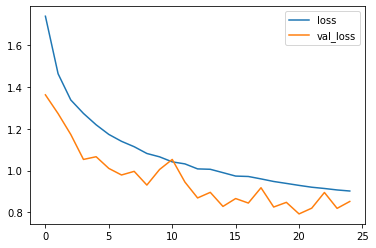

500/500 [==============================] - 126s 251ms/step - loss: 0.9022 - accuracy: 0.6844 - val_loss: 0.8523 - val_accuracy: 0.7064


In [20]:
#initialize model
modelCNN_cifar10 = Sequential()

#define model
modelCNN_cifar10.add(Conv2D(60,                      #number of filters
                          kernel_size=(3,3),         #Dimension of window
                          strides=(1,1),             #step size
                          padding='same',            #Padding: same=dim(in)=dim(out), valid=no Padding
                          activation='relu',         #Activation function
                          input_shape=(32,32,3)))    #Dimension of Input

modelCNN_cifar10.add(Dropout(0.05))

modelCNN_cifar10.add(MaxPooling2D(pool_size=(3, 3),  #MaxPooling Fenstergröße 3x3
                                  strides=(1,1)))    #step size


modelCNN_cifar10.add(Conv2D(30, kernel_size=(3,3), 
                          strides=(1,1),             #step size
                          padding='same',            #Padding: same=dim(in)=dim(out), valid=no Padding
                          activation='relu'))

modelCNN_cifar10.add(Dropout(0.05))

modelCNN_cifar10.add(MaxPooling2D(pool_size=(3, 3),
                                  strides=(1,1)))


modelCNN_cifar10.add(Flatten())                       #generate feature vector
modelCNN_cifar10.add(Dense(100,activation='relu'))
modelCNN_cifar10.add(Dense(10, activation='softmax')) #dense layer - acts as classifier!

#Adam
myAdam=keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

#RMS Prop
myRMSprop=keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)

# define a learning rate schedule
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.01,  # initial learning rate
    decay_steps=100000,          # number of steps before it starts
    decay_rate=0.96,             # Factor of decay
    staircase=False              # smooth decay if False, step decay if True
)

# SGD optimizer with learning rate schedule
sgd = SGD(learning_rate=lr_schedule, momentum=0.9, nesterov=True)

#comlile model
modelCNN_cifar10.compile(
    optimizer=sgd, 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

#train model with Data Augmentation
historyCNN_cifar10=modelCNN_cifar10.fit_generator(datagen.flow(trainX, trainY, batch_size=100), 
    epochs=25,  # Epochs
    steps_per_epoch=trainX.shape[0]//100,  # images per Epoche
    validation_data=(testX, testY), # Test data
    validation_steps=testX.shape[0]//100,
    verbose=1,
    callbacks=[plot_losses])

In [21]:
modelCNN_cifar10.evaluate(testX, testY)

313/313 [==============================] - 8s 24ms/step - loss: 0.8523 - accuracy: 0.7064


[0.8522753715515137, 0.7063999772071838]

### 6.3) Keras - use implemented topologies

Keras provides many successful NN Topologies

https://keras.io/api/applications/

The networks can either be loaded pre-trained (with weights already adjusted) or untrained. Whether it makes sense to use transfer learning, i.e., leveraging pre-trained models, depends on the task at hand.

Let's go ahead and use a pre-trained model (on ImageNet data). In this case, we will use EfficientNetB5:

https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet/EfficientNetB5


In [22]:
from tensorflow.keras.applications import EfficientNetB5

In [23]:
trainY.shape[1]

10

In [24]:
#Defining the model
base_model = EfficientNetB5(include_top=False, weights="imagenet", input_shape=(32,32,3),classes=trainY.shape[1])


115263384/115263384 [==============================] - 38s 0us/step


In [25]:
#Adding the final layers to the above base models where the actual classification is done in the dense layers

model= Sequential()
model.add(base_model) 
model.add(Flatten()) 

#Model summary
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb5 (Functional  (None, 1, 1, 2048)        28513527  
 )                                                               
                                                                 
 flatten_4 (Flatten)         (None, 2048)              0         
                                                                 
Total params: 28513527 (108.77 MB)
Trainable params: 28340784 (108.11 MB)
Non-trainable params: 172743 (674.78 KB)
_________________________________________________________________


In [26]:
#Adding the Dense layers along with activation and batch normalization
model.add(Dense(1024,activation=('relu'),input_dim=512)) # inputDim = 32x32

model.add(Dense(512,activation=('relu'))) 
model.add(Dense(256,activation=('relu'))) 
#model.add(Dropout(.3))
model.add(Dense(128,activation=('relu')))
#model.add(Dropout(.2))
model.add(Dense(10,activation=('softmax'))) 

#Checking the final model summary
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb5 (Functional  (None, 1, 1, 2048)        28513527  
 )                                                               
                                                                 
 flatten_4 (Flatten)         (None, 2048)              0         
                                                                 
 dense_8 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_9 (Dense)             (None, 512)               524800    
                                                                 
 dense_10 (Dense)            (None, 256)               131328    
                                                                 
 dense_11 (Dense)            (None, 128)               32896     
                                                      

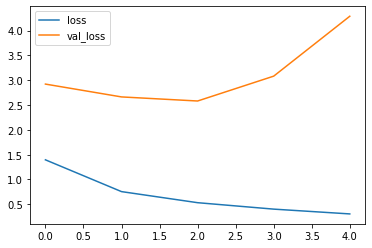

100/100 [==============================] - 997s 10s/step - loss: 0.3060 - accuracy: 0.8974 - val_loss: 4.2899 - val_accuracy: 0.1534


In [27]:
#Compiling the model
model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])

#compile model
model.compile(
    optimizer=myAdam, 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

#train model
history_model=model.fit(trainX, trainY, 
          validation_data=(testX, testY),                              
          epochs=5,
          batch_size=500,
          verbose=1,
          callbacks=[plot_losses])

In [28]:
model.evaluate(testX, testY)

313/313 [==============================] - 25s 68ms/step - loss: 4.2899 - accuracy: 0.1534


[4.28986930847168, 0.1534000039100647]

### Exercise 2)

The network does not perform very nicely (e.g. overfitting problems).

- read the documentation for EfficientNetB5
- reduce the training set so that the model trains quicker. Experiment with the top classifier and adopt it so that the model performs better
- select another topology (read documentation) and compare the results.
- Train the best net with the complete dataset.
- Does data augmentation improve the result?